In this notebook, we explore the application of Directed Acyclic Graph (DAG)-based Graph Neural Networks (GNNs) to learn a diffusion model over a DAG structure. The objective is to test whether different an architectures are capable of predicting the output signals given some sparse inputs. Leveraging the inherent structure of the DAG will play a fundamental role in the performance of the considered architectures.

In [1]:
import numpy as np
import time
import dgl
import torch
from torch import nn
import networkx as nx
from tqdm.auto import tqdm

import src.dag_utils as dagu
import src.utils as utils
from src.arch import DAGConv, FB_DAGConv, SF_DAGConv, ADCN
from src.models import Model, LinDAGRegModel
from src.baselines_archs import GAT, MLP, MyGCNN, GraphSAGE, GIN

import os

# Ser random seed
SEED = 10
PATH = 'results/diffusion/'
SAVE = True
np.random.seed(SEED)
torch.manual_seed(SEED)
dgl.random.seed(SEED)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
# torch.cuda.set_per_process_memory_fraction(.5, device=device)

cuda:0


## Default parameters and auxiliary functions

In [2]:
M = 2000

data_p = {
    'n_tries': 25,  #25,

    ## Graph parameters
    'p': 0.2,  # .2                  # Edge prob in Erdos-Renyi DAG
    'N': 100,                    # Number of nodes

    ## Signal parameters
    'M': M,                   # Number of observed signals
    'M_train': int(0.7 * M),  # Samples selected for training
    'M_val': int(0.2 * M),    # Samples selected for validation
    'M_test': int(0.1 * M),   # Samples selected for test
    'src_t': 'constant',          # 'random' or 'constant'
    'max_src_node': 25, #25,           # Maximum index of nodes allowed to be sources
    'n_sources': 5,             # Maximum Number of source nodes
    'n_p_x': .05,
    'n_p_y': .05,                 # Normalized noise power
    'max_GSO': 100,              # Maximum index of GSOs involved in the diffusion
    'min_GSO': 50,               # Minimum index of GSOs involved in the diffusion
    'n_GSOs': 25                 # Number of GSOs
}

# Model parameters
default_arch_args = {
    'in_dim': 1,        # Input dimension
    'hid_dim': 32,     # Hidden dimension
    'out_dim': 1,       # Output dimension
    'n_layers': 2,#2,  # 3 also works well          # Number of layers
    'l_act': None,
    'bias': True,
}

default_mod_p = {
    'bs': 25,           # Size of the batch
    'lr': 5e-4,         # Learning rate
    'epochs': 50,  #50,       # Number of training epochs 
    'pat': 25,  # 15        # Number of non-decreasing epoch to stop training
    'wd': 1e-4,         # Weight decay
}

In [3]:
def get_signals(d_p, GSOs):
    range_GSO = np.arange(d_p['min_GSO'], d_p['max_GSO'])
    gsos_idx = np.random.choice(range_GSO, size=d_p['n_GSOs'], replace=False)
    sel_GSOs = GSOs[gsos_idx]
    Yn_t, X_t, Y_t = dagu.create_diff_data(d_p['M'], sel_GSOs, d_p['max_src_node'], d_p['n_p_x'], d_p['n_p_y'],
                                           d_p['n_sources'], src_t=d_p['src_t'], torch_tensor=True, verb=False)
    
    X_data = {'train': X_t[:d_p['M_train']], 'val': X_t[d_p['M_train']:-d_p['M_test']], 'test': X_t[-d_p['M_test']:]}
    Y_data = {'train': Yn_t[:d_p['M_train']], 'val': Yn_t[d_p['M_train']:-d_p['M_test']],
              'test': Y_t[-d_p['M_test']:]}
        
    return X_data, Y_data, sel_GSOs, gsos_idx

def run_exps(exps, d_arc_args, d_mod_p, d_dat_p, GSOs, W, Adj, pbar, Psi=None, verb=True, exp_desc='default'):
    # Create error variables
    err_exps = np.zeros(len(exps))
    std_exps = np.zeros(len(exps))
    times_exps = np.zeros(len(exps))

    # Check if every experiment has the same signal setting
    common_signals = all('dat_p' not in exp for exp in exps)
    if common_signals:
        X_data, Y_data, sel_GSOs, sel_GSOs_idx = get_signals(d_dat_p, GSOs)

    for k, exp in enumerate(exps):
        # Combine default and experiment parameters
        arc_p = {**exp['arc_p']}
        arc_p['args'] = {**d_arc_args, **arc_p['args']} if 'args' in arc_p.keys() else {**d_arc_args}
        mod_p = {**d_mod_p, **exp['mod_p']} if 'mod_p' in exp else d_mod_p

        if not common_signals:
            d_p = {**d_dat_p, **exp['dat_p']}
            X_data, Y_data, sel_GSOs, sel_GSOs_idx = get_signals(d_p, GSOs)

        if exp['arc_p']['arch'] == LinDAGRegModel:
            Psi_sel = utils.select_GSO(arc_p, Psi.T, Psi[:,sel_GSOs_idx].T, W, Adj, sel_GSOs_idx).numpy().T
            lin_model = LinDAGRegModel(W, Psi_sel)
            t_i = time.time()
            lin_model.fit(X_data['train'], Y_data['train'])
            t_e = time.time() - t_i

            err_exps[k], std_exps[k] = lin_model.test(X_data['test'], Y_data['test'])
        else:
            GSO = utils.select_GSO(arc_p, GSOs, sel_GSOs, W, Adj, sel_GSOs_idx=sel_GSOs_idx)
            K = GSO.shape[0] if isinstance(GSO, torch.Tensor) and len(GSO.shape) == 3 else 0  
            arch = utils.instantiate_arch(arc_p, K)
            model = Model(arch, device=device)

            t_i = time.time()
            model.fit(X_data, Y_data, GSO, mod_p['lr'], mod_p['epochs'], mod_p['bs'], mod_p['wd'],
                    patience=mod_p['pat'])
            t_e = time.time() - t_i

            err_exps[k], std_exps[k] = model.test(X_data['test'], Y_data['test'], GSO)
        times_exps[k] = t_e

        # Progress
        pbar.update(1)
        if verb:
            print(f'\t-{exp_desc}. {exp["leg"]}: err: {err_exps[k]:.3f} - time: {times_exps[k]:.1f}')

    return err_exps, std_exps, times_exps

def run_exp(d_p, d_arc_args, d_mod_p, exps, verb=True):
    # Create error variables
    err = np.zeros((d_p['n_tries'], len(exps)))
    std = np.zeros((d_p['n_tries'], len(exps)))
    times = np.zeros((d_p['n_tries'], len(exps)))

    t_begin = time.time()
    # for i in range(d_p['n_tries']):
    with tqdm(total=d_p['n_tries']*len(exps), disable=False) as pbar:
        for i in range(d_p['n_tries']):
            Adj, W, GSOs, Psi = utils.get_graph_data(d_p, get_Psi=True)
            X_data, Y_data, sel_GSOs, sel_GSOs_idx = get_signals(d_p, GSOs)
            
            for j, exp in enumerate(exps):
                # Combine default and experiment parameters    
                arc_p = {**exp['arc_p']}
                arc_p['args'] = {**d_arc_args, **arc_p['args']} if 'args' in arc_p.keys() else {**d_arc_args}
                mod_p = {**d_mod_p, **exp['mod_p']} if 'mod_p' in exp.keys() else d_mod_p

                if exp['arc_p']['arch'] == LinDAGRegModel:
                    # Fit and test linear model
                    if 'transp' in arc_p.keys() and arc_p['transp']:
                        dag_T = nx.from_numpy_array(Adj, create_using=nx.DiGraph())
                        Psi = np.array([dagu.compute_Dq(dag_T, i, d_p['N']) for i in range(d_p['N'])]).T
                        arc_p['transp'] = False

                    Psi_sel = utils.select_GSO(arc_p, Psi.T, Psi[:,sel_GSOs_idx].T, W, Adj, sel_GSOs_idx).numpy().T
                    lin_model = LinDAGRegModel(W, Psi_sel)
                    t_i = time.time()
                    lin_model.fit(X_data['train'], Y_data['train'])
                    t_e = time.time() - t_i

                    err[i,j], std[i,j] = lin_model.test(X_data['test'], Y_data['test'])
                else:
                    # Fit and test nonlinear models
                    GSO = utils.select_GSO(arc_p, GSOs, sel_GSOs, W, Adj)
                    K = GSO.shape[0] if isinstance(GSO, torch.Tensor) and len(GSO.shape) == 3 else 0  
                    arch = utils.instantiate_arch(arc_p, K)                
                    model = Model(arch, device=device)

                    t_i = time.time()
                    model.fit(X_data, Y_data, GSO, mod_p['lr'], mod_p['epochs'], mod_p['bs'], mod_p['wd'], patience=mod_p['pat'])
                    t_e = time.time() - t_i
                    err[i,j], std[i,j] = model.test(X_data['test'], Y_data['test'], GSO)

                times[i,j] = t_e

                params = arch.n_params if hasattr(arch, 'n_params') else None 
                
                # Progress
                pbar.update(1)
                if verb:
                    print(f'-{i}. {exp["leg"]}: err: {err[i,j]:.3f} | std: {std[i,j]:.3f}  |' +
                          f' time: {times[i,j]:.1f} | n_params: {params}')

    total_t = (time.time() - t_begin)/60
    print(f'----- Ellapsed time: {total_t:.2f} minutes -----')
    return err, std, times

## Preliminary results

In [4]:
mod_p_init = default_mod_p.copy()
mod_p_init['pat'] = 50

verb = True

# Experiments to be run
Exps = [
    # Our Models
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'GSOs'}, 'leg': 'DCN'},
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'rnd_GSOs', 'n_gsos': 30}, 'leg': 'DCN-30'},
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'rnd_GSOs', 'n_gsos': 10}, 'leg': 'DCN-10'},
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'rnd_GSOs', 'n_gsos': 5}, 'leg': 'DCN-5'},

    # {'arc_p': {'arch': DAGConv, 'GSO': 'GSOs'}, 'leg': 'DAGConv'},
    # {'arc_p': {'arch': DAGConv, 'GSO': 'rnd_GSOs', 'n_gsos': 30}, 'leg': 'DAGConv-30'},

    {'arc_p': {'arch': ADCN, 'GSO': 'GSOs', 'args': {'mlp_layers': 4}}, 'leg': 'ADCN-4-2'},
    {'arc_p': {'arch': ADCN, 'GSO': 'GSOs', 'args': {'mlp_layers': 5}}, 'leg': 'ADCN-5-2'},
    {'arc_p': {'arch': ADCN, 'GSO': 'GSOs', 'args': {'mlp_layers': 4, 'n_layers': 4}}, 'leg': 'ADCN-4-4'},
    {'arc_p': {'arch': ADCN, 'GSO': 'GSOs', 'args': {'mlp_layers': 5, 'n_layers': 4}}, 'leg': 'ADCN-5-4'},


    # Our Models - Transposed
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'GSOs', 'transp': True}, 'leg': 'DCN-T'},
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'rnd_GSOs', 'n_gsos': 30, 'transp': True}, 'leg': 'DCN-30-T'},
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'rnd_GSOs', 'n_gsos': 10, 'transp': True}, 'leg': 'DCN-10-T'},

    # {'arc_p': {'arch': DAGConv, 'GSO': 'GSOs', 'transp': True}, 'leg': 'DAGConv-T'},
    # {'arc_p': {'arch': DAGConv, 'GSO': 'rnd_GSOs', 'n_gsos': 30, 'transp': True}, 'leg': 'DAGConv-30-T'},

    # {'arc_p': {'arch': ADCN, 'GSO': 'GSOs', 'transp': True, 'args': {'mlp_layers': 4}}, 'leg': 'ADCN-4-T'},
    # {'arc_p': {'arch': ADCN, 'GSO': 'GSOs', 'transp': True, 'args': {'mlp_layers': 5}}, 'leg': 'ADCN-5-T'},

    # Linear baselines
    {'arc_p': {'arch': LinDAGRegModel, 'GSO': 'GSOs'}, 'leg': 'Linear'},
    # {'arc_p': {'arch': LinDAGRegModel, 'GSO': 'rnd_GSOs', 'n_gsos': 30}, 'leg': 'Linear-30'},
    # {'arc_p': {'arch': LinDAGRegModel, 'GSO': 'rnd_GSOs', 'n_gsos': 10}, 'leg': 'Linear-10'},
    {'arc_p': {'arch': LinDAGRegModel, 'GSO': 'GSOs', 'transp': True}, 'leg': 'Linear-T'},
    # {'arc_p': {'arch': LinDAGRegModel, 'GSO': 'rnd_GSOs', 'n_gsos': 30, 'transp': True}, 'leg': 'Linear-30-T'},
    # {'arc_p': {'arch': LinDAGRegModel, 'GSO': 'rnd_GSOs', 'n_gsos': 10, 'transp': True}, 'leg': 'Linear-10-T'},

    # GNN Baselines
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'A_pows', 'K': 2, 'transp': False}, 'leg': 'FB-GCNN-2'},
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'A_pows', 'K': 3, 'transp': False}, 'leg': 'FB-GCNN-3'},
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'A_pows', 'K': 4, 'transp': False}, 'leg': 'FB-GCNN-4'},
    {'arc_p': {'arch': MyGCNN, 'GSO': 'A'}, 'leg': 'GNN-A'},
    {'arc_p': {'arch': GAT, 'GSO': 'A-dgl', 'args': {'num_heads': 2, 'hid_dim': 16, 'gat_params': {'attn_drop': 0}}},
     'leg': 'GAT'},
    {'arc_p': {'arch': GraphSAGE, 'GSO': 'A-dgl', 'args': {'aggregator': 'mean'}}, 'leg': 'GraphSAGE-A'},
    {'arc_p': {'arch': GIN, 'GSO': 'A-dgl', 'args': {'aggregator': 'sum'}}, 'leg': 'GIN-A'},
    {'arc_p': {'arch': GIN, 'GSO': 'A-dgl', 'args': {'aggregator': 'sum', 'mlp_layers': 4}}, 'leg': 'GIN-A-4'},
    {'arc_p': {'arch': MLP, 'GSO': None}, 'leg': 'MLP'},
    {'arc_p': {'arch': MLP, 'GSO': None, 'args': {'n_layers': 4}}, 'leg': 'MLP-4'},
]

err, std, times = run_exp(data_p, default_arch_args, mod_p_init, Exps, verb=verb)

  0%|          | 0/575 [00:00<?, ?it/s]

-0. DCN: err: 0.020 | std: 0.010  | time: 4.8 | n_params: 6433
-0. DCN-30: err: 0.038 | std: 0.015  | time: 3.8 | n_params: 1953
-0. DCN-10: err: 0.097 | std: 0.027  | time: 3.4 | n_params: 673
-0. DCN-5: err: 0.140 | std: 0.050  | time: 3.7 | n_params: 353
-0. ADCN-4-2: err: 0.140 | std: 0.053  | time: 8.1 | n_params: 6433
-0. ADCN-5-2: err: 0.140 | std: 0.057  | time: 9.0 | n_params: 8545
-0. ADCN-4-4: err: 0.114 | std: 0.037  | time: 14.5 | n_params: 14881
-0. ADCN-5-4: err: 0.116 | std: 0.039  | time: 16.9 | n_params: 19105
-0. DCN-T: err: 0.097 | std: 0.030  | time: 4.2 | n_params: 6433
-0. DCN-30-T: err: 0.144 | std: 0.038  | time: 3.9 | n_params: 1953
-0. DCN-10-T: err: 0.200 | std: 0.085  | time: 3.6 | n_params: 673
-0. Linear: err: 0.081 | std: 0.022  | time: 0.4 | n_params: 673
-0. Linear-T: err: 0.081 | std: 0.022  | time: 0.5 | n_params: 673
-0. FB-GCNN-2: err: 0.208 | std: 0.098  | time: 3.8 | n_params: 161
-0. FB-GCNN-3: err: 0.189 | std: 0.100  | time: 3.9 | n_params: 22

In [5]:
# DEFAULT PARAMETERS
if SAVE:
    file_name = PATH + f'init_exp-{data_p["src_t"]}'
    np.savez(file_name, err=err, std=std, times=times)
    print('SAVED FILE:', file_name)

leg = [exp['leg'] for exp in Exps]

utils.display_data(leg, err, std, times)

SAVED FILE: results/diffusion/init_exp-constant


,Exp,Mean Err,Median Err,Mean Std,time
0,DCN,0.018052,0.013386,0.013443,3.997443
1,DCN-30,0.045841,0.019480,0.020933,3.898802
2,DCN-10,0.074970,0.033703,0.028463,3.662218
3,DCN-5,0.109118,0.036185,0.036800,3.670520
4,ADCN-4-2,0.103472,0.045621,0.037717,8.095667
5,ADCN-5-2,0.096032,0.045220,0.034542,9.349198
6,ADCN-4-4,0.096352,0.048070,0.035398,15.095915
7,ADCN-5-4,0.074386,0.033294,0.027095,17.696903
8,DCN-T,0.096861,0.089637,0.029448,4.712306
9,DCN-30-T,0.187630,0.160743,0.038650,3.822229


In [6]:
# file_name = PATH + 'gso_inf-constant.npz'
# err, std, times, Exps, N_GSOs = utils.load_data(file_name)

## Noise Influence Experiment

In [7]:
def influence_noise(d_dat_p, d_arc_p, d_mod_p, Noise_values, exps, noise_keys=['n_p_y']):
    err = np.zeros((d_dat_p['n_tries'], len(Noise_values), len(exps)))
    std = np.zeros((d_dat_p['n_tries'], len(Noise_values), len(exps)))
    times = np.zeros((d_dat_p['n_tries'], len(Noise_values), len(exps)))

    t_begin = time.time()
    with tqdm(total=d_dat_p['n_tries']*len(exps)*len(Noise_values), disable=False) as pbar:
        for i in range(d_dat_p['n_tries']):
            print('Realization:', i)

            for j, noise in enumerate(Noise_values):
                data_params_aux = dict(d_dat_p)
                for key in noise_keys:
                    data_params_aux[key] = noise

                Adj, W, GSOs, Psi = utils.get_graph_data(data_params_aux, get_Psi=True)
                err[i,j], std[i,j], times[i,j] = run_exps(exps, d_arc_p, d_mod_p, data_params_aux, GSOs, W, Adj,
                                                          pbar, exp_desc=str(noise), Psi=Psi)

                err[i,j][err[i,j] > 1] = 1

    total_t = (time.time() - t_begin)/60
    print(f'----- Ellapsed time: {total_t:.2f} minutes -----')

    return err, std, times

In [8]:
M = 2000
# data_soruces = dict(data_p)
# data_soruces['n_p_y'] = 0

Noise_values = np.arange(0, .51, .05)

[1, 2, 4, 5, 6, 7, 10]

Exps = [
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'GSOs'}, 'leg': 'DCN', 'fmt': 'o-'},
    # {'arc_p': {'arch': FB_DAGConv, 'GSO': 'rnd_GSOs', 'n_gsos': 20}, 'leg': 'DCN-20',
    #  'fmt': 's--'},
    # {'arc_p': {'arch': FB_DAGConv, 'GSO': 'rnd_GSOs', 'n_gsos': 10}, 'leg': 'DCN-10',
    #  'fmt': 's--'},

    {'arc_p': {'arch': LinDAGRegModel, 'GSO': 'GSOs'}, 'leg': 'Linear', 'fmt': '1-'},
    # {'arc_p': {'arch': LinDAGRegModel, 'GSO': 'rnd_GSOs', 'n_gsos': 20}, 'leg': 'Linear-Rnd-20', 'fmt': '1:'},
    # {'arc_p': {'arch': LinDAGRegModel, 'GSO': 'rnd_GSOs', 'n_gsos': 10}, 'leg': 'Linear-Rnd-10', 'fmt': '1:'},

    # {'arc_p': {'arch': FB_DAGConv, 'GSO': 'A_pows', 'K': 2, 'transp': False}, 'leg': 'FB-GCNN-2', 'fmt': '2:'},
    # {'arc_p': {'arch': FB_DAGConv, 'GSO': 'A_pows', 'K': 4, 'transp': False}, 'leg': 'FB-GCNN-3', 'fmt': '2--'},
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'A_pows', 'K': 6, 'transp': False}, 'leg': 'FB-GCNN-4', 'fmt': '2-'},

    {'arc_p': {'arch': MyGCNN, 'GSO': 'A'}, 'leg': 'GNN-A', 'fmt': 'v:'},
    # {'arc_p': {'arch': GAT, 'GSO': 'A-dgl', 'args': {'num_heads': 2, 'hid_dim': 16, 'gat_params': {'attn_drop': 0}}},
    #  'leg': 'GAT-A', 'fmt': '^:'},
    {'arc_p': {'arch': GraphSAGE, 'GSO': 'A-dgl', 'args': {'hid_dim': 16, 'aggregator': 'mean'}}, 'leg': 'GraphSAGE-A',
     'fmt': '>:'},
    {'arc_p': {'arch': GIN, 'GSO': 'A-dgl',  'args': {'hid_dim': 16, 'aggregator': 'sum'}}, 'leg': 'GIN-A',
     'fmt': '<:'},

    {'arc_p': {'arch': ADCN, 'GSO': 'GSOs', 'args': {'mlp_layers': 5, 'n_layers': 4}}, 'leg': 'ADCN-5', 'fmt': 'p-'},
]

err, std, times = influence_noise(data_p, default_arch_args, default_mod_p, Noise_values, Exps,
                                  noise_keys=['n_p_x', 'n_p_y'])


  0%|          | 0/1925 [00:00<?, ?it/s]

Realization: 0
	-0.0. DCN: err: 0.009 - time: 3.0
	-0.0. Linear: err: 0.008 - time: 0.4
	-0.0. FB-GCNN-4: err: 0.017 - time: 3.0
	-0.0. GNN-A: err: 0.230 - time: 3.3
	-0.0. GraphSAGE-A: err: 0.299 - time: 6.1
	-0.0. GIN-A: err: 0.319 - time: 5.5
	-0.0. ADCN-5: err: 0.011 - time: 18.0
	-0.05. DCN: err: 0.010 - time: 4.0
	-0.05. Linear: err: 0.041 - time: 0.4
	-0.05. FB-GCNN-4: err: 0.046 - time: 3.6
	-0.05. GNN-A: err: 0.127 - time: 3.7
	-0.05. GraphSAGE-A: err: 0.162 - time: 6.2
	-0.05. GIN-A: err: 0.195 - time: 5.8
	-0.05. ADCN-5: err: 0.030 - time: 17.4
	-0.1. DCN: err: 0.013 - time: 4.1
	-0.1. Linear: err: 0.042 - time: 0.4
	-0.1. FB-GCNN-4: err: 0.024 - time: 3.9
	-0.1. GNN-A: err: 0.151 - time: 3.9
	-0.1. GraphSAGE-A: err: 0.344 - time: 6.6
	-0.1. GIN-A: err: 0.415 - time: 6.7
	-0.1. ADCN-5: err: 0.011 - time: 18.5
	-0.15000000000000002. DCN: err: 0.010 - time: 4.1
	-0.15000000000000002. Linear: err: 0.044 - time: 0.4
	-0.15000000000000002. FB-GCNN-4: err: 0.021 - time: 2.8
	-0.15

SAVED FILE: results/diffusion/noise/noise_inf-constant
SAVED as: results/diffusion/noise/noise_inf-constant-mean_err.csv
SAVED as: results/diffusion/noise/noise_inf-constant-std_up_err.csv
SAVED as: results/diffusion/noise/noise_inf-constant-std_down_err.csv
SAVED as: results/diffusion/noise/noise_inf-constant-med_err.csv
SAVED as: results/diffusion/noise/noise_inf-constant-prct75_err.csv
SAVED as: results/diffusion/noise/noise_inf-constant-prct25_err.csv


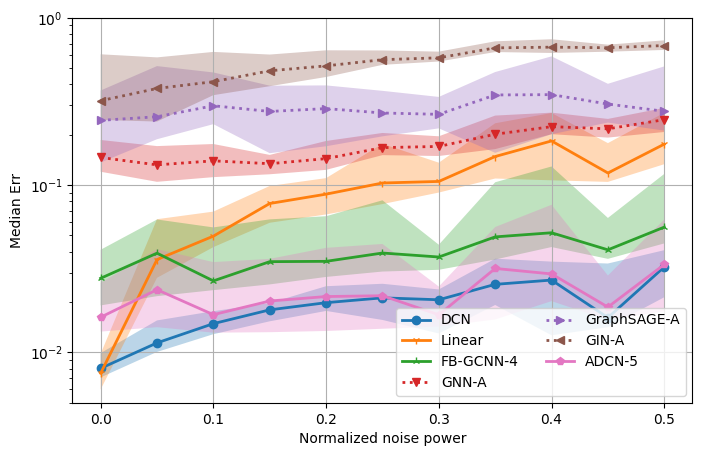

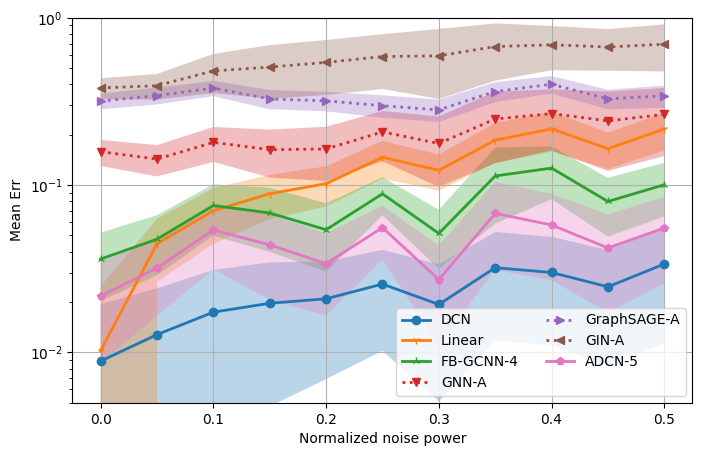

In [9]:
mean_err = err.mean(axis=0)
std_err = std.mean(axis=0)
med_err = np.median(err, axis=0)
prctile25_err = np.percentile(err, 25, axis=0)
prctile75_err = np.percentile(err, 75, axis=0)

if SAVE:
    file_name = PATH + f'noise/noise_inf-{data_p["src_t"]}'
    np.savez(file_name, err=err, std=std, times=times, exp=Exps, xvals=Noise_values)
    print('SAVED FILE:', file_name)

    # Save csv files for pgfplot
    file_name_data = f'{file_name}-mean_err.csv'
    utils.data_to_csv(file_name_data, Exps, Noise_values, mean_err)
    file_name_data = f'{file_name}-std_up_err.csv'
    utils.data_to_csv(file_name_data, Exps, Noise_values, mean_err + std_err)
    file_name_data = f'{file_name}-std_down_err.csv'
    utils.data_to_csv(file_name_data, Exps, Noise_values, mean_err - std_err)
    file_name_data = f'{file_name}-med_err.csv'
    utils.data_to_csv(file_name_data, Exps, Noise_values, med_err)
    file_name_data = f'{file_name}-prct75_err.csv'
    utils.data_to_csv(file_name_data, Exps, Noise_values, prctile75_err)
    file_name_data = f'{file_name}-prct25_err.csv'
    utils.data_to_csv(file_name_data, Exps, Noise_values, prctile25_err)

legend = [exp['leg'] for exp in Exps]

skip = []  # [1, 2, 4, 5, 6, 7, 10] #[1,3,5,6, 7, 11, 12]
utils.plot_results(med_err, Noise_values, Exps, 'Normalized noise power', skip_idx=skip, n_cols=2, ylabel='Median Err',
                   ylim_top=1, logy=True, prctile_up=prctile75_err, prctile_low=prctile25_err, ylim_bottom=5e-3)

utils.plot_results(mean_err, Noise_values, Exps, 'Normalized noise power', skip_idx=skip, n_cols=2, ylabel='Mean Err',
                   ylim_top=1, logy=True, std=std_err, ylim_bottom=5e-3)




In [10]:
# file_name = PATH + 'noise/noise_inf-constant-noisy_test.npz'
# err, std, times, Exps, Noise_values = utils.load_data(file_name)

## Additional Eperiments

### Varying the size of the graph

In [10]:
def influence_graph_size(d_dat_p, d_arc_p, d_mod_p, N_nodes, mean_edges_per_node, exps,
                         sel_GSOs='last', incr_GSOs=True, inc_srcs=True):
    err = np.zeros((d_dat_p['n_tries'], len(N_nodes), len(exps)))
    std = np.zeros((d_dat_p['n_tries'], len(N_nodes), len(exps)))
    times = np.zeros((d_dat_p['n_tries'], len(N_nodes), len(exps)))
    
    t_begin = time.time()
    with tqdm(total=d_dat_p['n_tries']*len(exps)*len(N_nodes), disable=False) as pbar:
        for i in range(d_dat_p['n_tries']):
            print('Realization:', i)

            for j, n_nodes in enumerate(N_nodes):
                data_params_aux = dict(d_dat_p)
                data_params_aux['N'] = n_nodes
                edges = n_nodes*mean_edges_per_node
                data_params_aux['p'] = float(edges*2)/float(n_nodes**2 - n_nodes)

                if inc_srcs:
                    data_params_aux['max_src_node'] = int(n_nodes/4)
                    data_params_aux['n_sources'] = max(int(n_nodes/20), 1)

                if sel_GSOs == 'all':
                    data_params_aux['max_GSO'] = n_nodes
                    data_params_aux['min_GSO'] = 0
                else:
                    # Always use second half of nodes to generate data
                    data_params_aux['max_GSO'] = n_nodes
                    data_params_aux['min_GSO'] = int(n_nodes/2)
                
                available_nodes = data_params_aux['max_GSO'] - data_params_aux['min_GSO']
                if incr_GSOs: # and available_nodes > d_dat_p['n_GSOs']:
                    data_params_aux['n_GSOs'] = int(available_nodes/2)  # max(int(available_nodes/2), d_dat_p['n_GSOs'])
                else:
                    data_params_aux['n_GSOs'] = min(d_dat_p['n_GSOs'], available_nodes)
                

                Adj, W, GSOs, Psi = utils.get_graph_data(data_params_aux, get_Psi=True)

                exp_desc = f'N: {Adj.shape[0]}, p: { data_params_aux["p"]:.3f}'

                err[i,j], std[i,j], times[i,j] = run_exps(exps, d_arc_p, d_mod_p, data_params_aux, GSOs, W,
                                                          Adj, pbar, exp_desc=exp_desc, Psi=Psi)

                err[i,j][err[i,j] > 1] = 1

    total_t = (time.time() - t_begin)/60
    print(f'----- Ellapsed time: {total_t:.2f} minutes -----')

    return err, std, times

In [11]:
mean_edges_per_node = 5
N_nodes = np.array([25, 50, 100, 200, 400]) # np.logspace(np.log10(25), np.log10(400), 7, dtype=int) 

Exps = [
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'GSOs'}, 'leg': 'DCN', 'fmt': 'o-'},
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'rnd_GSOs', 'n_gsos': 20}, 'leg': 'DCN-20', 'fmt': 'o--'},

    {'arc_p': {'arch': LinDAGRegModel, 'GSO': 'GSOs'}, 'leg': 'Linear', 'fmt': 's-'},

    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'A_pows', 'K': 4, 'transp': False}, 'leg': 'FB-GCNN-3', 'fmt': '2:'},
    {'arc_p': {'arch': MyGCNN, 'GSO': 'A'}, 'leg': 'GNN-A', 'fmt': 'v:'},
    {'arc_p': {'arch': GAT, 'GSO': 'A-dgl', 'args': {'num_heads': 2, 'hid_dim': 16, 'gat_params': {'attn_drop': 0}}},
     'leg': 'GAT-A', 'fmt': '^:'},
    {'arc_p': {'arch': GraphSAGE, 'GSO': 'A-dgl', 'args': {'hid_dim': 16, 'aggregator': 'mean'}}, 'leg': 'GraphSAGE-A',
     'fmt': '>:'},
    {'arc_p': {'arch': GIN, 'GSO': 'A-dgl', 'args': {'hid_dim': 16, 'aggregator': 'sum'}}, 'leg': 'GIN-A',
     'fmt': '<:'},
    
    {'arc_p': {'arch': ADCN, 'GSO': 'GSOs', 'args': {'mlp_layers': 5, 'n_layers': 4}}, 'leg': 'ADCN-5', 'fmt': 'p-'},
    ]

err, std, times = influence_graph_size(data_p, default_arch_args, default_mod_p, N_nodes,
                                       mean_edges_per_node, Exps)


  0%|          | 0/1125 [00:00<?, ?it/s]

Realization: 0
	-N: 25, p: 0.417. DCN: err: 0.005 - time: 3.2
	-N: 25, p: 0.417. DCN-20: err: 0.006 - time: 3.8
	-N: 25, p: 0.417. Linear: err: 0.054 - time: 0.0
	-N: 25, p: 0.417. FB-GCNN-3: err: 0.423 - time: 3.8
	-N: 25, p: 0.417. GNN-A: err: 0.605 - time: 3.6
	-N: 25, p: 0.417. GAT-A: err: 0.762 - time: 14.3
	-N: 25, p: 0.417. GraphSAGE-A: err: 0.616 - time: 6.5
	-N: 25, p: 0.417. GIN-A: err: 0.621 - time: 6.8
	-N: 25, p: 0.417. ADCN-5: err: 0.013 - time: 15.9
	-N: 50, p: 0.204. DCN: err: 0.039 - time: 3.7
	-N: 50, p: 0.204. DCN-20: err: 0.040 - time: 3.5
	-N: 50, p: 0.204. Linear: err: 0.066 - time: 0.1
	-N: 50, p: 0.204. FB-GCNN-3: err: 0.117 - time: 3.4
	-N: 50, p: 0.204. GNN-A: err: 0.205 - time: 3.6
	-N: 50, p: 0.204. GAT-A: err: 0.622 - time: 14.7
	-N: 50, p: 0.204. GraphSAGE-A: err: 0.160 - time: 6.4
	-N: 50, p: 0.204. GIN-A: err: 0.185 - time: 6.6
	-N: 50, p: 0.204. ADCN-5: err: 0.046 - time: 15.8
	-N: 100, p: 0.101. DCN: err: 0.048 - time: 4.3
	-N: 100, p: 0.101. DCN-20: e

SAVED FILE: results/diffusion/graph_size/n_nodes_inf-constant
SAVED as: results/diffusion/graph_size/n_nodes_inf-constant-mean_err.csv
SAVED as: results/diffusion/graph_size/n_nodes_inf-constant-std_up_err.csv
SAVED as: results/diffusion/graph_size/n_nodes_inf-constant-std_down_err.csv
SAVED as: results/diffusion/graph_size/n_nodes_inf-constant-med_err.csv
SAVED as: results/diffusion/graph_size/n_nodes_inf-constant-prct75_err.csv
SAVED as: results/diffusion/graph_size/n_nodes_inf-constant-prct25_err.csv


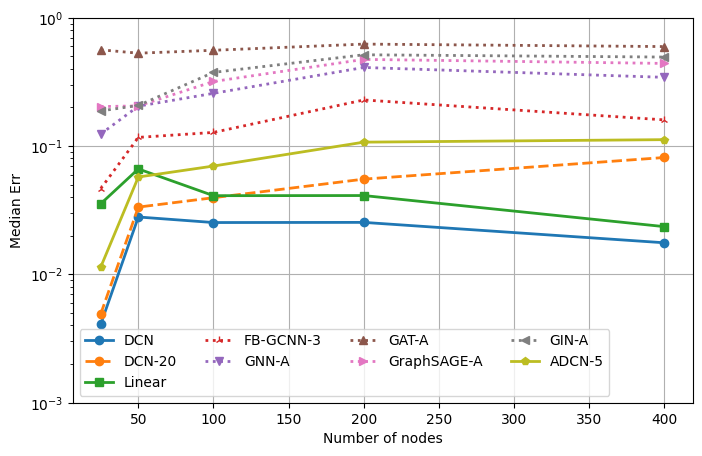

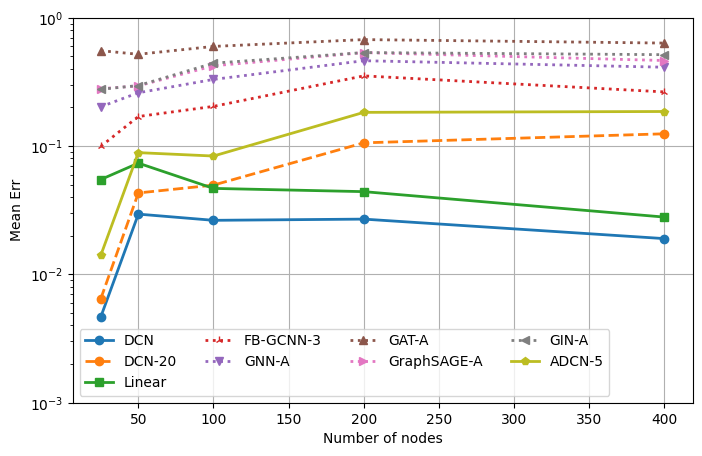

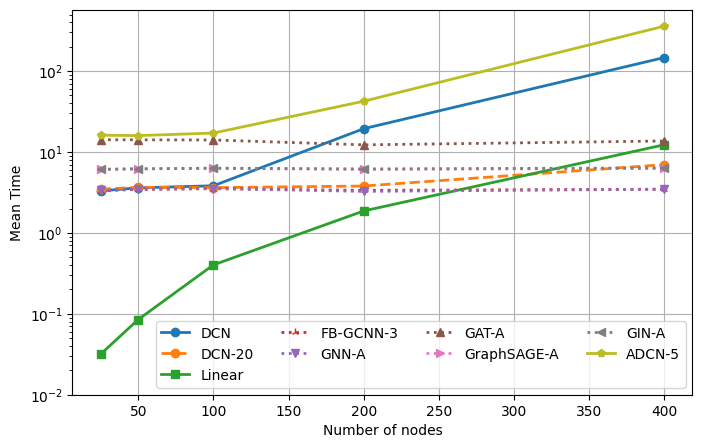

In [12]:
mean_err = err.mean(axis=0)
std_err = err.std(axis=0)
med_err = np.median(err, axis=0)
std_err = err.std(axis=0)
prctile25_err = np.percentile(err, 25, axis=0)
prctile75_err = np.percentile(err, 75, axis=0)
mean_time = times.mean(axis=0)

if SAVE:
    file_name = PATH + f'graph_size/n_nodes_inf-{data_p["src_t"]}'
    np.savez(file_name, err=err, std=std, times=times, exp=Exps, xvals=N_nodes)
    print('SAVED FILE:', file_name)

    # Save csv files for pgfplot
    file_name_data = f'{file_name}-mean_err.csv'
    utils.data_to_csv(file_name_data, Exps, N_nodes, mean_err)
    file_name_data = f'{file_name}-std_up_err.csv'
    utils.data_to_csv(file_name_data, Exps, N_nodes, mean_err + std_err)
    file_name_data = f'{file_name}-std_down_err.csv'
    utils.data_to_csv(file_name_data, Exps, N_nodes, mean_err - std_err)
    file_name_data = f'{file_name}-med_err.csv'
    utils.data_to_csv(file_name_data, Exps, N_nodes, med_err)
    file_name_data = f'{file_name}-prct75_err.csv'
    utils.data_to_csv(file_name_data, Exps, N_nodes, prctile75_err)
    file_name_data = f'{file_name}-prct25_err.csv'
    utils.data_to_csv(file_name_data, Exps, N_nodes, prctile25_err)


### WITH PRCTILES
skip = []  # [1, 6, 9]
legend = [exp['leg'] for exp in Exps]
utils.plot_results(med_err, N_nodes, Exps, 'Number of nodes', skip_idx=skip, n_cols=4,
                   ylabel='Median Err', logy=True, ylim_top=1, ylim_bottom=1e-3)

utils.plot_results(mean_err, N_nodes, Exps, 'Number of nodes', skip_idx=skip, n_cols=4,
                   ylabel='Mean Err', logy=True, ylim_top=1, ylim_bottom=1e-3)

utils.plot_results(mean_time, N_nodes, Exps, 'Number of nodes', skip_idx=skip, n_cols=4,
                   ylabel='Mean Time', logy=True, ylim_top=None, ylim_bottom=1e-2)

In [14]:
# file_name = PATH + 'graph_size/n_nodes_inf-constant.npz'
# err, std, times, Exps, N_nodes = utils.load_data(file_name)

### Influence of selected GSOs

In [4]:
def influence_gso_exp(d_dat_p, d_arc_p, d_mod_p, N_GSOs, exps):
    err = np.zeros((d_dat_p['n_tries'], len(N_GSOs), len(exps)))
    std = np.zeros((d_dat_p['n_tries'], len(N_GSOs), len(exps)))
    times = np.zeros((d_dat_p['n_tries'], len(N_GSOs), len(exps)))
    t_begin = time.time()

    with tqdm(total=d_dat_p['n_tries']*len(exps)*len(N_GSOs), disable=False) as pbar:
        for i in range(d_dat_p['n_tries']):
            print('Iteration:', i)
            Adj, W, GSOs, Psi = utils.get_graph_data(d_dat_p, get_Psi=True)

            for j, n_gsos in enumerate(N_GSOs):
                data_params_aux = dict(d_dat_p)
                data_params_aux['n_GSOs'] = n_gsos
                err[i,j], std[i,j], times[i,j] = run_exps(exps, d_arc_p, d_mod_p, data_params_aux, GSOs, W,
                                                        Adj, pbar, Psi=Psi, exp_desc=str(n_gsos))

    total_t = (time.time() - t_begin)/60
    print(f'----- Ellapsed time: {total_t:.2f} minutes -----')
    return err, std, times


In [5]:
Exps = [
    {'dat_p': {'min_GSO': 0, 'max_GSO': 100}, 'arc_p': {'arch': FB_DAGConv, 'GSO': 'GSOs'}, 'mod_p': {},
     'leg': 'DCN, All', 'fmt': 'o-'},
    # {'arc_p': {'arch': LinDAGRegModel, 'GSO': 'GSOs'}, 'leg': 'Linear', 'fmt': '1-'},
    {'dat_p': {'min_GSO': 0, 'max_GSO': 100}, 'arc_p': {'arch': FB_DAGConv, 'GSO': 'rnd_GSOs', 'n_gsos': 20},
     'mod_p': {}, 'leg': 'DCN-Rnd-20, All', 'fmt': 's-'},
    {'dat_p': {'min_GSO': 0, 'max_GSO': 100}, 'arc_p': {'arch': FB_DAGConv, 'GSO': 'A_pows', 'K': 3, 'transp': False},
     'leg': 'FB-GCNN-3', 'fmt': '2-'},


    
    
    {'dat_p': {'min_GSO': 0, 'max_GSO': 60}, 'arc_p': {'arch': FB_DAGConv, 'GSO': 'GSOs'}, 'mod_p': {},
     'leg': 'DCN, Firsts', 'fmt': 'o--'},
    {'dat_p': {'min_GSO': 0, 'max_GSO': 60}, 'arc_p': {'arch': FB_DAGConv, 'GSO': 'rnd_GSOs', 'n_gsos': 20},
     'mod_p': {}, 'leg': 'DCN-Rnd-20, Firsts', 'fmt': 's--'},
    {'dat_p': {'min_GSO': 0, 'max_GSO': 60}, 'arc_p': {'arch': FB_DAGConv, 'GSO': 'A_pows', 'K': 3, 'transp': False},
     'leg': 'FB-GCNN-3', 'fmt': '2--'},

    {'dat_p': {'min_GSO': 40, 'max_GSO': 100}, 'arc_p': {'arch': FB_DAGConv, 'GSO': 'GSOs'}, 'mod_p': {},
     'leg': 'DCN, Lasts', 'fmt': 'o:'},
    {'dat_p': {'min_GSO': 40, 'max_GSO': 100}, 'arc_p': {'arch': FB_DAGConv, 'GSO': 'rnd_GSOs', 'n_gsos': 20},
     'leg': 'DCN-Rnd-20, Lasts', 'fmt': 's:'},
    {'dat_p': {'min_GSO': 40, 'max_GSO': 100}, 'arc_p': {'arch': FB_DAGConv, 'GSO': 'A_pows', 'K': 3, 'transp': False},
     'leg': 'FB-GCNN-3', 'fmt': '2:'},
    ]

N_GSOs = np.arange(5, 41, 5)

err, std, times = influence_gso_exp(data_p, default_arch_args, default_mod_p, N_GSOs, Exps)

  0%|          | 0/1800 [00:00<?, ?it/s]

Iteration: 0
	-5. DCN, All: err: 0.081 - time: 4.5
	-5. DCN-Rnd-20, All: err: 0.014 - time: 3.8


KeyboardInterrupt: 

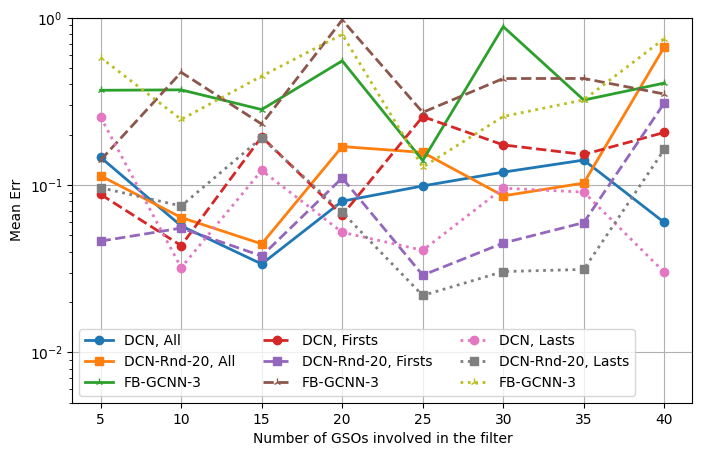

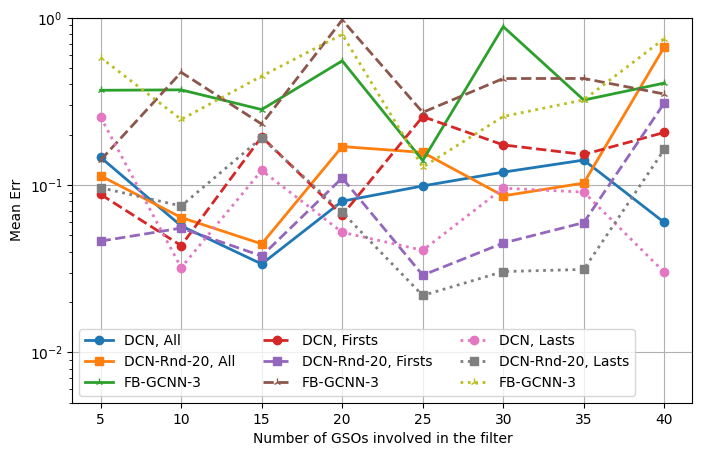

In [17]:
if SAVE:
    file_name = PATH + f'gso_inf-{data_p["src_t"]}'
    np.savez(file_name, err=err, std=std, times=times, exp=Exps, xvals=N_GSOs)
    print('SAVED FILE:', file_name)

mean_err = err.mean(axis=0)
med_err = np.median(err, axis=0)

skip_idx = [] # [2, 3, 6, 7, 10, 11]
utils.plot_results(mean_err, N_GSOs, Exps, 'Number of GSOs involved in the filter',
                   skip_idx=skip_idx, n_cols=3, ylim_bottom=5e-3)

utils.plot_results(med_err, N_GSOs, Exps, 'Number of GSOs involved in the filter',
                   skip_idx=skip_idx, n_cols=3, ylim_bottom=5e-3)

# skip_idx = [0, 1, 4, 5, 8, 9]
# utils.plot_results(med_err, N_GSOs, Exps, 'Number of GSOs involved in the filter',
#                    skip_idx=skip_idx, n_cols=3)

In [18]:
# file_name = PATH + 'gso_inf-constant.npz'
# err, std, times, Exps, N_GSOs = utils.load_data(file_name)

### Influence of the number of source nodes

In [19]:
def influence_sources_exp(d_dat_p, d_arc_p, d_mod_p, N_sources, exps):
    err = np.zeros((d_dat_p['n_tries'], len(N_sources), len(exps)))
    std = np.zeros((d_dat_p['n_tries'], len(N_sources), len(exps)))
    times = np.zeros((d_dat_p['n_tries'], len(N_sources), len(exps)))
    
    t_begin = time.time()
    with tqdm(total=d_dat_p['n_tries']*len(exps)*len(N_sources), disable=False) as pbar:
        for i in range(d_dat_p['n_tries']):
            print('Iteration:', i)

            Adj, W, GSOs, Psi = utils.get_graph_data(d_dat_p, get_Psi=True)

            for j, n_sources in enumerate(N_sources):
                data_params_aux = dict(d_dat_p)
                data_params_aux['n_sources'] = n_sources
                err[i,j], std[i,j], times[i,j] = run_exps(exps, d_arc_p, d_mod_p, data_params_aux, GSOs, W,
                                                        Adj, pbar, Psi=Psi, exp_desc=str(n_sources))

    total_t = (time.time() - t_begin)/60
    print(f'----- Ellapsed time: {total_t:.2f} minutes -----')
    return err, std, times

In [20]:
M = 2000
data_soruces = dict(data_p)
data_soruces['max_src_node'] = 50

N_sources = [1, 10, 20, 30, 40, 50]  #[1, 5, 10, 15, 20, 25]

Exps = [
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'GSOs'}, 'mod_p': {}, 'leg': 'DCN', 'fmt': 'o-'},
    # {'arc_p': {'arch': FB_DAGConv, 'GSO': 'sel_GSOs'}, 'mod_p': {}, 'leg': 'DCN-Prior', 'fmt': 'P--'},
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'rnd_GSOs', 'n_gsos': 20}, 'mod_p': {}, 'leg': 'DCN-20', 'fmt': 'o--'},

    {'arc_p': {'arch': LinDAGRegModel, 'GSO': 'GSOs'}, 'leg': 'Linear', 'fmt': 's-'},
    {'arc_p': {'arch': LinDAGRegModel, 'GSO': 'rnd_GSOs', 'n_gsos': 20}, 'leg': 'Linear-20', 'fmt': 's--'},

    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'A_pows', 'K': 4, 'transp': False}, 'leg': 'FB-GCNN-3', 'fmt': '1:'},
    {'arc_p': {'arch': MyGCNN, 'GSO': 'A'}, 'leg': 'GNN-A', 'fmt': 'v:'},
    {'arc_p': {'arch': GAT, 'GSO': 'A-dgl', 'args': {'num_heads': 2, 'hid_dim': 16, 'gat_params': {'attn_drop': 0}}},
     'leg': 'GAT-A', 'fmt': '^:'},
    {'arc_p': {'arch': GraphSAGE, 'GSO': 'A-dgl', 'args': {'hid_dim': 16, 'aggregator': 'mean'}}, 'leg': 'GraphSAGE-A',
     'fmt': '>:'},
    {'arc_p': {'arch': GIN, 'GSO': 'A-dgl', 'args': {'hid_dim': 16, 'aggregator': 'sum'}}, 'leg': 'GIN-A',
     'fmt': '<:'},
    ]

err, std, times = influence_sources_exp(data_soruces, default_arch_args, default_mod_p, N_sources, Exps)


  0%|          | 0/54 [00:00<?, ?it/s]

Iteration: 0
	-1. DCN: err: 0.029 - time: 0.2
	-1. DCN-20: err: 0.019 - time: 0.2
	-1. Linear: err: 0.035 - time: 1.6
	-1. Linear-20: err: 0.043 - time: 0.6
	-1. FB-GCNN-3: err: 0.590 - time: 0.4
	-1. GNN-A: err: 0.958 - time: 0.2
	-1. GAT-A: err: 0.896 - time: 1.0
	-1. GraphSAGE-A: err: 108.869 - time: 0.6
	-1. GIN-A: err: 0.565 - time: 0.7
	-10. DCN: err: 0.079 - time: 0.2
	-10. DCN-20: err: 0.132 - time: 0.3
	-10. Linear: err: 0.035 - time: 1.7
	-10. Linear-20: err: 0.066 - time: 0.6
	-10. FB-GCNN-3: err: 0.450 - time: 0.4
	-10. GNN-A: err: 0.588 - time: 0.4
	-10. GAT-A: err: 0.763 - time: 1.1
	-10. GraphSAGE-A: err: 5.586 - time: 0.6
	-10. GIN-A: err: 0.709 - time: 0.7
	-20. DCN: err: 0.074 - time: 0.3
	-20. DCN-20: err: 0.090 - time: 0.3
	-20. Linear: err: 0.027 - time: 1.2
	-20. Linear-20: err: 0.063 - time: 0.5
	-20. FB-GCNN-3: err: 0.090 - time: 0.2
	-20. GNN-A: err: 0.278 - time: 0.2
	-20. GAT-A: err: 0.705 - time: 0.9
	-20. GraphSAGE-A: err: 401.550 - time: 0.8
	-20. GIN-A: e

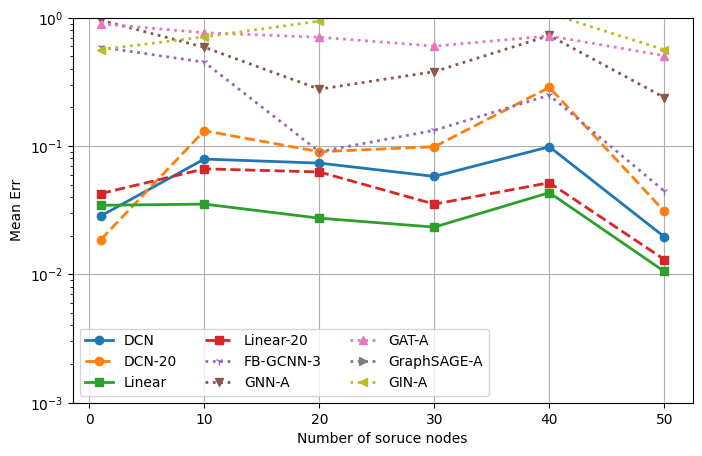

In [21]:
if SAVE:
    file_name = PATH + f'sel_nodes/src_nodes_inf-{data_p["src_t"]}'
    np.savez(file_name, err=err, std=std, times=times, exp=Exps, xvals=N_sources)
    print('SAVED FILE:', file_name)

mean_err = err.mean(axis=0)
med_err = np.median(err, axis=0)
legend = [exp['leg'] for exp in Exps]
utils.plot_results(mean_err, N_sources, Exps, 'Number of soruce nodes', ylim_bottom=1e-3)


In [22]:
# file_name = PATH + 'src_nodes_inf-constant.npz'
# err, std, times, Exps, N_sources = utils.load_data(file_name)

### Number of randomly selected GSOs

In [13]:
def influence_selected_gsp_exp(d_dat_p, d_arc_p, d_mod_p, N_GSOs, exps):
    err = np.zeros((d_dat_p['n_tries'], len(N_GSOs), len(exps)))
    std = np.zeros((d_dat_p['n_tries'], len(N_GSOs), len(exps)))
    times = np.zeros((d_dat_p['n_tries'], len(N_GSOs), len(exps)))
    
    t_begin = time.time()
    with tqdm(total=d_dat_p['n_tries']*len(exps)*len(N_GSOs), disable=False) as pbar:
        for i in range(d_dat_p['n_tries']):
            print('Realization:', i)

            Adj, W, GSOs, Psi = utils.get_graph_data(d_dat_p, get_Psi=True)

            for j, n_gsos in enumerate(N_GSOs):
                exps_aux = exps.copy()
                [exp['arc_p'].update({'n_gsos': n_gsos})  for exp in exps_aux]

                err[i,j], std[i,j], times[i,j] = run_exps(exps_aux, d_arc_p, d_mod_p, d_dat_p, GSOs, W,
                                                          Adj, pbar, Psi=Psi, exp_desc=str(n_gsos))

    total_t = (time.time() - t_begin)/60
    print(f'----- Ellapsed time: {total_t:.2f} minutes -----')
    return err, std, times

#### Data generated with all GSOs

In [33]:
data_rnd_gsos = dict(data_p)
data_rnd_gsos['min_GSO'] = 0
data_rnd_gsos['max_GSO'] = 100
data_rnd_gsos['p'] = .1

M = 2000
N_GSOs = [5, 10, 15, 20, 25, 30, 45, 50, 55, 60]

Exps = [
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'GSOs'}, 'leg': 'DCN', 'fmt': 'o-'},
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'rnd_GSOs'}, 'leg': 'DCN-Rnd', 'fmt': 'v-'},
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'first_GSOs'}, 'leg': 'DCN-First', 'fmt': '^-'},
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'last_GSOs'}, 'leg': 'DCN-Last', 'fmt': '>-'},
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'no_sel_GSOs'}, 'leg': 'DCN-NoSel', 'fmt': '<-'},

    {'arc_p': {'arch': LinDAGRegModel, 'GSO': 'GSOs'}, 'leg': 'Linear', 'fmt': '1--'},
    {'arc_p': {'arch': LinDAGRegModel, 'GSO': 'rnd_GSOs'}, 'leg': 'Linear-Rnd', 'fmt': '2--'},
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'A_pows', 'K': 4, 'transp': False}, 'leg': 'FB-GCNN-4', 'fmt': '3:'},
    ]

err, std, times = influence_selected_gsp_exp(data_rnd_gsos, default_arch_args, default_mod_p, N_GSOs, Exps)


  0%|          | 0/80 [00:00<?, ?it/s]

Realization: 0
	-5. DCN: err: 0.111 - time: 0.1
	-5. DCN-Rnd: err: 0.324 - time: 0.1
	-5. DCN-First: err: 0.672 - time: 0.1
	-5. DCN-Last: err: 0.456 - time: 0.1
	-5. DCN-NoSel: err: 0.337 - time: 0.1
	-5. Linear: err: 0.078 - time: 0.3
	-5. Linear-Rnd: err: 0.482 - time: 0.1
	-5. FB-GCNN-4: err: 0.559 - time: 0.1
	-10. DCN: err: 0.038 - time: 0.1
	-10. DCN-Rnd: err: 0.078 - time: 0.1
	-10. DCN-First: err: 0.637 - time: 0.1
	-10. DCN-Last: err: 0.128 - time: 0.1
	-10. DCN-NoSel: err: 0.133 - time: 0.1
	-10. Linear: err: 0.030 - time: 0.3
	-10. Linear-Rnd: err: 0.071 - time: 0.1
	-10. FB-GCNN-4: err: 0.470 - time: 0.1
	-15. DCN: err: 0.060 - time: 0.1
	-15. DCN-Rnd: err: 0.144 - time: 0.1
	-15. DCN-First: err: 0.641 - time: 0.1
	-15. DCN-Last: err: 0.130 - time: 0.1
	-15. DCN-NoSel: err: 0.138 - time: 0.1
	-15. Linear: err: 0.045 - time: 0.3
	-15. Linear-Rnd: err: 0.105 - time: 0.1
	-15. FB-GCNN-4: err: 0.620 - time: 0.1
	-20. DCN: err: 0.107 - time: 0.1
	-20. DCN-Rnd: err: 0.271 - time

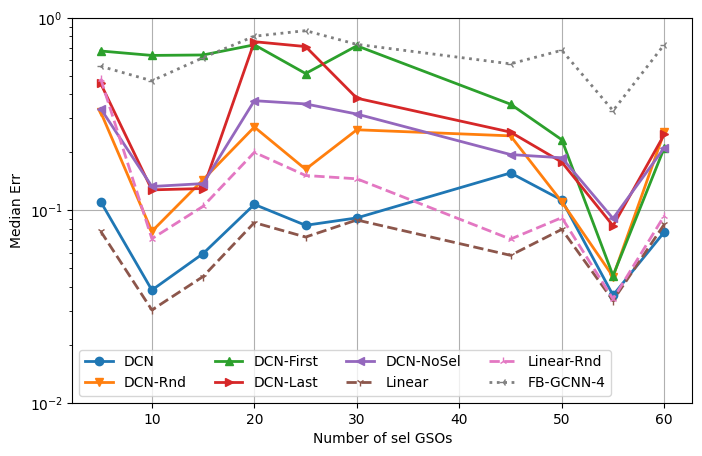

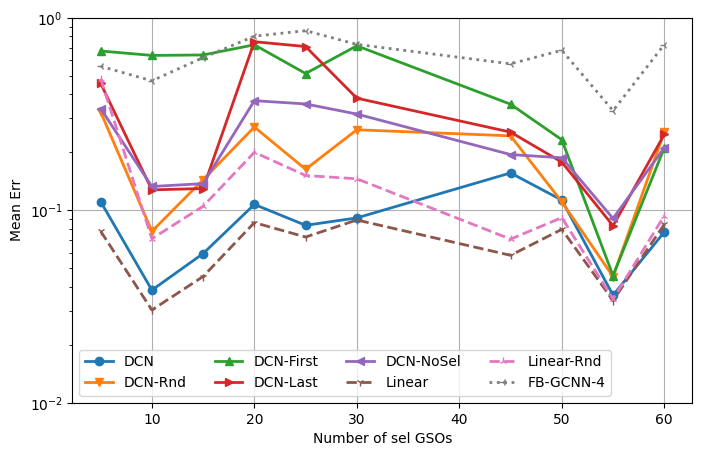

In [34]:
if SAVE:
    file_name = PATH + f'sel_gso_inf-from_all_gso-{data_p["src_t"]}'
    np.savez(file_name, err=err, std=std, times=times, exp=Exps, xvals=N_GSOs)
    print('SAVED FILE:', file_name)

mean_err = err.mean(axis=0)
mean_time = times.mean(axis=0)
med_err = np.median(err, axis=0)
med_time = np.median(times, axis=0)
legend = [exp['leg'] for exp in Exps]

# Selected
# skip = [0, 1, 2]
utils.plot_results(mean_err, N_GSOs, Exps, 'Number of sel GSOs', n_cols=4, ylabel='Median Err')

# All
utils.plot_results(med_err, N_GSOs, Exps, 'Number of sel GSOs', n_cols=4)

In [35]:
# file_name = PATH + 'sel_gso_inf-from_all_gso-constant.npz'
# err, std, times, Exps, N_GSOs = utils.load_data(file_name)

#### Data generated with last GSOs

In [36]:
M = 2000
N_GSOs = [5, 10, 15, 20, 25, 30, 45, 50]

data_rnd_gsos = dict(data_p)
data_rnd_gsos['min_GSO'] = 49
data_rnd_gsos['max_GSO'] = 100
data_rnd_gsos['p'] = .1

Exps = [
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'GSOs'}, 'mod_p': {}, 'leg': 'DCN', 'fmt': 'o-'},
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'rnd_GSOs'}, 'mod_p': {}, 'leg': 'DCN-Rnd', 'fmt': 'v-'},
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'first_GSOs'}, 'mod_p': {}, 'leg': 'DCN-First', 'fmt': '^-'},
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'last_GSOs'}, 'mod_p': {}, 'leg': 'DCN-Last', 'fmt': '>-'},
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'no_sel_GSOs'}, 'mod_p': {}, 'leg': 'DCN-NoSel', 'fmt': '<-'},

    {'arc_p': {'arch': LinDAGRegModel, 'GSO': 'GSOs'}, 'leg': 'Linear', 'fmt': '1--'},
    {'arc_p': {'arch': LinDAGRegModel, 'GSO': 'rnd_GSOs'}, 'leg': 'Linear-Rnd', 'fmt': '2--'},
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'A_pows', 'K': 4, 'transp': False}, 'leg': 'FB-GCNN-4', 'fmt': '3:'},
    ]

err, std, times = influence_selected_gsp_exp(data_rnd_gsos, default_arch_args, default_mod_p, N_GSOs, Exps)


  0%|          | 0/64 [00:00<?, ?it/s]

Realization: 0
	-5. DCN: err: 0.102 - time: 0.1
	-5. DCN-Rnd: err: 0.570 - time: 0.1
	-5. DCN-First: err: 0.829 - time: 0.1
	-5. DCN-Last: err: 0.206 - time: 0.1
	-5. DCN-NoSel: err: 0.611 - time: 0.1
	-5. Linear: err: 0.063 - time: 0.3
	-5. Linear-Rnd: err: 0.179 - time: 0.1
	-5. FB-GCNN-4: err: 0.488 - time: 0.1
	-10. DCN: err: 0.069 - time: 0.1
	-10. DCN-Rnd: err: 0.403 - time: 0.1
	-10. DCN-First: err: 0.806 - time: 0.1
	-10. DCN-Last: err: 0.119 - time: 0.1
	-10. DCN-NoSel: err: 0.387 - time: 0.1
	-10. Linear: err: 0.060 - time: 0.3
	-10. Linear-Rnd: err: 0.128 - time: 0.1
	-10. FB-GCNN-4: err: 0.533 - time: 0.1
	-15. DCN: err: 0.085 - time: 0.1
	-15. DCN-Rnd: err: 0.240 - time: 0.1
	-15. DCN-First: err: 0.665 - time: 0.1
	-15. DCN-Last: err: 0.207 - time: 0.1
	-15. DCN-NoSel: err: 0.247 - time: 0.1
	-15. Linear: err: 0.047 - time: 0.3
	-15. Linear-Rnd: err: 0.145 - time: 0.1
	-15. FB-GCNN-4: err: 0.534 - time: 0.1
	-20. DCN: err: 0.060 - time: 0.1
	-20. DCN-Rnd: err: 0.136 - time

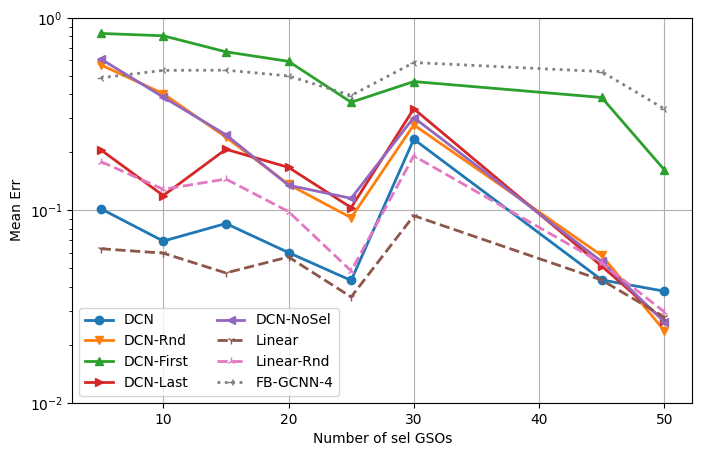

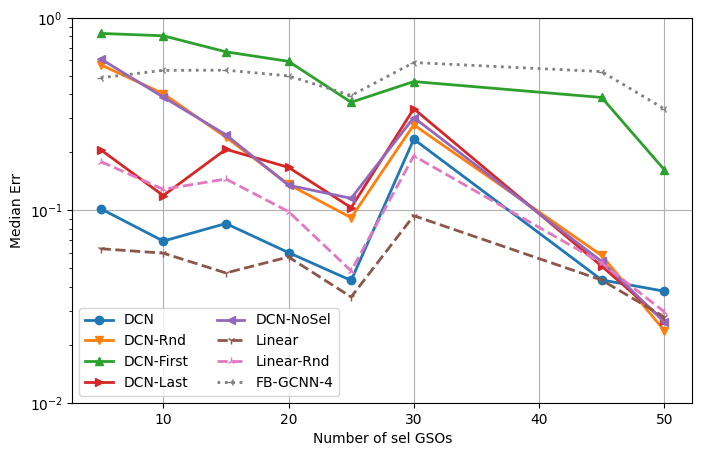

In [37]:
if SAVE:
    file_name = PATH + f'sel_gso_inf-{data_p["src_t"]}'
    np.savez(file_name, err=err, std=std, times=times, exp=Exps, xvals=N_GSOs)
    print('SAVED FILE:', file_name)

mean_err = err.mean(axis=0)
mean_time = times.mean(axis=0)
med_err = np.median(err, axis=0)
med_time = np.median(times, axis=0)
legend = [exp['leg'] for exp in Exps]
utils.plot_results(mean_err, N_GSOs, Exps, 'Number of sel GSOs', n_cols=2, ylabel='Mean Err')
utils.plot_results(med_err, N_GSOs, Exps, 'Number of sel GSOs', n_cols=2, ylabel='Median Err')

In [38]:
# file_name = PATH + 'sel_gso_inf-constant.npz'
# err, std, times, Exps, N_GSOs = utils.load_data(file_name)

### Influence of number of Layers

In [14]:
def influence_n_layers_exp(d_dat_p, d_arc_p, d_mod_p, N_layers, exps):
    err = np.zeros((d_dat_p['n_tries'], len(N_layers), len(exps)))
    std = np.zeros((d_dat_p['n_tries'], len(N_layers), len(exps)))
    times = np.zeros((d_dat_p['n_tries'], len(N_layers), len(exps)))
    
    t_begin = time.time()
    with tqdm(total=d_dat_p['n_tries']*len(exps)*len(N_layers), disable=False) as pbar:
        for i in range(d_dat_p['n_tries']):
            print('Realization:', i)

            Adj, W, GSOs, Psi = utils.get_graph_data(d_dat_p, get_Psi=True)

            for j, n_layers in enumerate(N_layers):
                arch_params_aux = dict(d_arc_p)
                arch_params_aux['n_layers'] = n_layers

                err[i,j], std[i,j], times[i,j] = run_exps(exps, arch_params_aux, d_mod_p, d_dat_p, GSOs, W,
                                                          Adj, pbar, Psi=Psi, exp_desc=str(n_layers))

                err[i,j][err[i,j] > 1] = 1

    total_t = (time.time() - t_begin)/60
    print(f'----- Ellapsed time: {total_t:.2f} minutes -----')

    return err, std, times

In [15]:
N_layers = np.arange(1,9)


Exps = [
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'GSOs'}, 'mod_p': {}, 'leg': 'DCN', 'fmt': 'o-'},
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'rnd_GSOs', 'n_gsos': 20}, 'mod_p': {}, 'leg': 'DCN-20', 'fmt': 'o--'},
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'rnd_GSOs', 'n_gsos': 10}, 'mod_p': {}, 'leg': 'DCN-10', 'fmt': 'o-.'},

    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'A_pows', 'K': 2, 'transp': False}, 'leg': 'FB-GCNN-2', 'fmt': '1:'},
    # {'arc_p': {'arch': FB_DAGConv, 'GSO': 'A_pows', 'K': 4, 'transp': False}, 'leg': 'FB-GCNN-4', 'fmt': '2:'},
    {'arc_p': {'arch': MyGCNN, 'GSO': 'A'}, 'leg': 'GNN-A', 'fmt': 'v:'},
    # {'arc_p': {'arch': GraphSAGE, 'GSO': 'A-dgl', 'args': {'hid_dim': 16, 'aggregator': 'mean'}}, 'leg': 'GraphSAGE-A',
    #  'fmt': '>:'},
    {'arc_p': {'arch': GIN, 'GSO': 'A-dgl', 'args': {'hid_dim': 16, 'aggregator': 'sum'}}, 'leg': 'GIN-A',
     'fmt': '<:'},

    {'arc_p': {'arch': ADCN, 'GSO': 'GSOs', 'args': {'mlp_layers': 2}}, 'leg': 'ADCN-2', 'fmt': 'p-'},
    {'arc_p': {'arch': ADCN, 'GSO': 'GSOs', 'args': {'mlp_layers': 3}}, 'leg': 'ADCN-3', 'fmt': 'p--'},
    {'arc_p': {'arch': ADCN, 'GSO': 'GSOs', 'args': {'mlp_layers': 5}}, 'leg': 'ADCN-5', 'fmt': 'p:'},
    ]

err, std, times = influence_n_layers_exp(data_p, default_arch_args, default_mod_p, N_layers, Exps)


  0%|          | 0/1800 [00:00<?, ?it/s]

Realization: 0
	-1. DCN: err: 0.082 - time: 2.0
	-1. DCN-20: err: 0.148 - time: 1.9
	-1. DCN-10: err: 0.140 - time: 2.0
	-1. FB-GCNN-2: err: 0.185 - time: 2.0
	-1. GNN-A: err: 0.463 - time: 1.9
	-1. GIN-A: err: 0.722 - time: 3.0
	-1. ADCN-2: err: 0.156 - time: 2.4
	-1. ADCN-3: err: 0.136 - time: 3.4
	-1. ADCN-5: err: 0.134 - time: 4.7
	-2. DCN: err: 0.015 - time: 4.0
	-2. DCN-20: err: 0.019 - time: 3.4
	-2. DCN-10: err: 0.032 - time: 4.0
	-2. FB-GCNN-2: err: 0.098 - time: 4.1
	-2. GNN-A: err: 0.121 - time: 3.2
	-2. GIN-A: err: 0.315 - time: 6.6
	-2. ADCN-2: err: 0.241 - time: 5.6
	-2. ADCN-3: err: 0.040 - time: 6.3
	-2. ADCN-5: err: 0.036 - time: 5.7
	-3. DCN: err: 0.014 - time: 10.0
	-3. DCN-20: err: 0.032 - time: 4.8
	-3. DCN-10: err: 0.030 - time: 4.9
	-3. FB-GCNN-2: err: 0.061 - time: 5.1
	-3. GNN-A: err: 0.114 - time: 5.4
	-3. GIN-A: err: 0.752 - time: 9.3
	-3. ADCN-2: err: 8.929 - time: 8.0
	-3. ADCN-3: err: 0.491 - time: 10.0
	-3. ADCN-5: err: 0.039 - time: 13.7
	-4. DCN: err: 0

SAVED FILE: results/diffusion/layers/n_layers_inf-constant


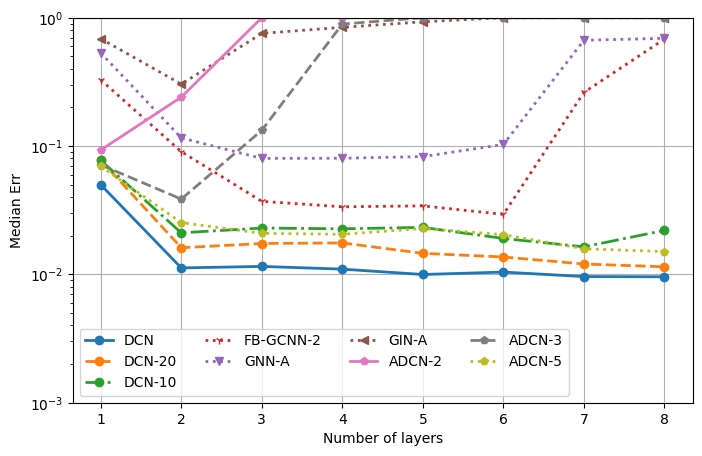

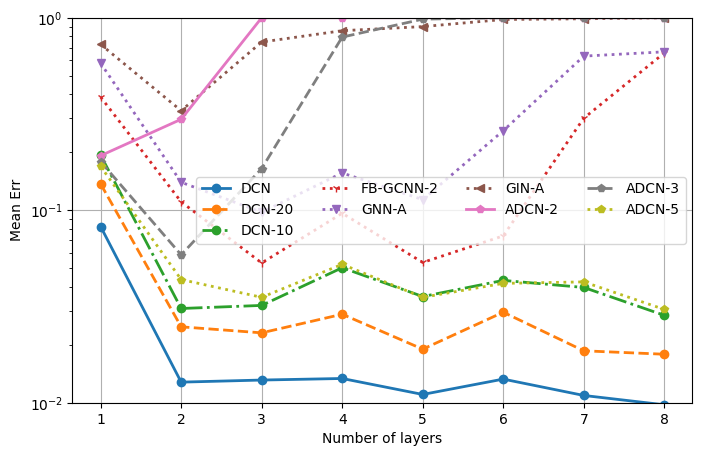

In [16]:
if SAVE:
    file_name = PATH + f'layers/n_layers_inf-{data_p["src_t"]}'
    np.savez(file_name, err=err, std=std, times=times, exp=Exps, xvals=N_layers)
    print('SAVED FILE:', file_name)

mean_err = err.mean(axis=0)
mean_time = times.mean(axis=0)
med_err = np.median(err, axis=0)
mean_std = np.mean(std, axis=0)
legend = [exp['leg'] for exp in Exps]
skip_idx = [8, 9, 10, 11]
# utils.plot_results(mean_err, N_layers, Exps, 'Number of layers', skip_idx=skip_idx, n_cols=2)
# utils.plot_results(mean_time, N_layers, Exps, 'Number of layer', ylabel='Mean time (seg)',
#                    skip_idx=skip_idx, n_cols=2, ylim_bottom=1, ylim_top=50)

# skip_idx = [0, 1, 2, 8]
# skip_idx = [0, 1, 2, 3, 5, 8]
skip_idx = []
utils.plot_results(med_err, N_layers, Exps, 'Number of layers', skip_idx=skip_idx, n_cols=4, ylabel='Median Err',
                   ylim_bottom=1e-3)
utils.plot_results(mean_err, N_layers, Exps, 'Number of layers', skip_idx=skip_idx, n_cols=4)



In [42]:
# file_name = PATH + 'layers/n_layers_inf-constant.npz'

### Varying the density of the graph

In [17]:
def influence_graph_density(d_dat_p, d_arc_p, d_mod_p, P_values, exps):
    err = np.zeros((d_dat_p['n_tries'], len(P_values), len(exps)))
    std = np.zeros((d_dat_p['n_tries'], len(P_values), len(exps)))
    times = np.zeros((d_dat_p['n_tries'], len(P_values), len(exps)))
    
    t_begin = time.time()
    with tqdm(total=d_dat_p['n_tries']*len(exps)*len(P_values), disable=False) as pbar:
        for i in range(d_dat_p['n_tries']):
            print('Realization:', i)

            for j, p in enumerate(P_values):
                data_params_aux = dict(d_dat_p)
                data_params_aux['p'] = p            
                Adj, W, GSOs, Psi = utils.get_graph_data(data_params_aux, get_Psi=True)

                err[i,j], std[i,j], times[i,j] = run_exps(exps, d_arc_p, d_mod_p, data_params_aux, GSOs, W,
                                                          Adj, pbar, exp_desc=str(p), Psi=Psi)

                err[i,j][err[i,j] > 1] = 1

    total_t = (time.time() - t_begin)/60
    print(f'----- Ellapsed time: {total_t:.2f} minutes -----')

    return err, std, times

In [18]:
P_values = [.1, .2, .3, .4, .5, .6, .7, .8]

Exps = [
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'GSOs'}, 'mod_p': {}, 'leg': 'DCN', 'fmt': 'o-'},
    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'rnd_GSOs', 'n_gsos': 20}, 'mod_p': {}, 'leg': 'DCN-20', 'fmt': 'o--'},

    {'arc_p': {'arch': LinDAGRegModel, 'GSO': 'GSOs'}, 'leg': 'Linear', 'fmt': 's-'},

    {'arc_p': {'arch': FB_DAGConv, 'GSO': 'A_pows', 'K': 4, 'transp': False}, 'leg': 'FB-GCNN-3', 'fmt': '2:'},
    {'arc_p': {'arch': MyGCNN, 'GSO': 'A'}, 'leg': 'GNN-A', 'fmt': 'v:'},
    {'arc_p': {'arch': GAT, 'GSO': 'A-dgl', 'args': {'num_heads': 2, 'hid_dim': 16, 'gat_params': {'attn_drop': 0}}},
     'leg': 'GAT-A', 'fmt': '^:'},
    {'arc_p': {'arch': GraphSAGE, 'GSO': 'A-dgl', 'args': {'hid_dim': 16, 'aggregator': 'mean'}}, 'leg': 'GraphSAGE-A',
     'fmt': '>:'},
    {'arc_p': {'arch': GIN, 'GSO': 'A-dgl', 'args': {'hid_dim': 16, 'aggregator': 'sum'}}, 'leg': 'GIN-A',
     'fmt': '<:'},
    
    {'arc_p': {'arch': ADCN, 'GSO': 'GSOs', 'args': {'mlp_layers': 5, 'n_layers': 4}}, 'leg': 'ADCN-5', 'fmt': 'p-'},
    ]

err, std, times = influence_graph_density(data_p, default_arch_args, default_mod_p, P_values, Exps)


  0%|          | 0/1800 [00:00<?, ?it/s]

Realization: 0
	-0.1. DCN: err: 0.012 - time: 4.3
	-0.1. DCN-20: err: 0.036 - time: 4.0
	-0.1. Linear: err: 0.028 - time: 0.8
	-0.1. FB-GCNN-3: err: 0.049 - time: 3.8
	-0.1. GNN-A: err: 0.185 - time: 3.8
	-0.1. GAT-A: err: 0.514 - time: 14.1
	-0.1. GraphSAGE-A: err: 0.168 - time: 5.4
	-0.1. GIN-A: err: 0.187 - time: 6.0
	-0.1. ADCN-5: err: 0.019 - time: 17.6
	-0.2. DCN: err: 0.009 - time: 4.1
	-0.2. DCN-20: err: 0.010 - time: 3.7
	-0.2. Linear: err: 0.025 - time: 0.6
	-0.2. FB-GCNN-3: err: 0.018 - time: 3.2
	-0.2. GNN-A: err: 0.101 - time: 3.3
	-0.2. GAT-A: err: 0.609 - time: 14.6
	-0.2. GraphSAGE-A: err: 0.246 - time: 6.1
	-0.2. GIN-A: err: 0.312 - time: 6.2
	-0.2. ADCN-5: err: 0.012 - time: 17.3
	-0.3. DCN: err: 0.009 - time: 4.1
	-0.3. DCN-20: err: 0.010 - time: 3.2
	-0.3. Linear: err: 0.023 - time: 0.4
	-0.3. FB-GCNN-3: err: 0.018 - time: 3.2
	-0.3. GNN-A: err: 0.073 - time: 3.1
	-0.3. GAT-A: err: 0.674 - time: 14.2
	-0.3. GraphSAGE-A: err: 0.362 - time: 6.5
	-0.3. GIN-A: err: 0.59

SAVED FILE: results/diffusion/density_inf-constant


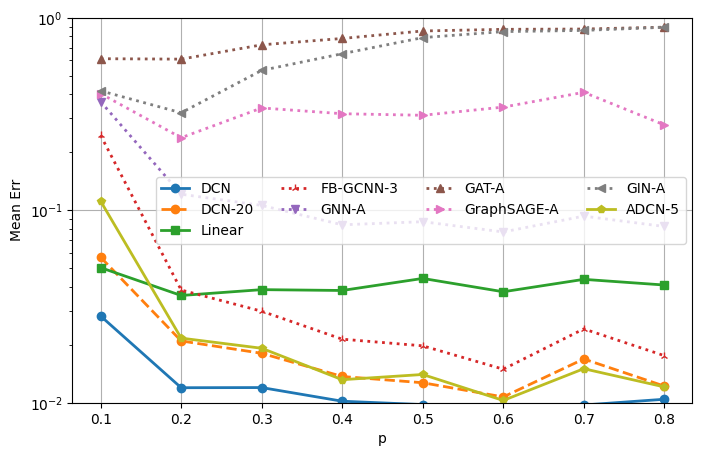

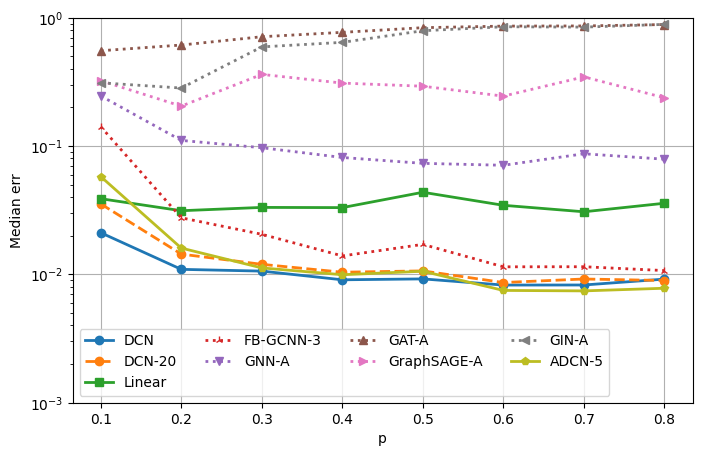

In [19]:
if SAVE:
    file_name = PATH + f'density_inf-{data_p["src_t"]}'
    np.savez(file_name, err=err, std=std, times=times, exp=Exps, xvals=P_values)
    print('SAVED FILE:', file_name)

mean_err = err.mean(axis=0)
mean_time = times.mean(axis=0)
med_err = np.median(err, axis=0)
legend = [exp['leg'] for exp in Exps]
utils.plot_results(mean_err, P_values, Exps, 'p', skip_idx=[], n_cols=4)

utils.plot_results(med_err, P_values, Exps, 'p', skip_idx=[], n_cols=4,
                   ylabel='Median err', ylim_bottom=1e-3)

In [48]:
# file_name = PATH + 'density_inf-constant.npz'
# err, std, times, Exps, P_values = utils.load_data(file_name)